In [84]:
import os
import pandas as pd
import numpy as np
import gzip
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from article_dataset import ArticleDataset

from transformers import BertTokenizerFast as BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device(type='cpu')

In [135]:
LABEL = 'major_topic_pred_index'
ARTICLE = 'article'

In [136]:
def read_folder(folder_path):
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jsonl.gz'):
            with gzip.open(os.path.join(folder_path, filename), 'rt', encoding='utf-8') as file:
                for line in file:
                    json_data = json.loads(line)
                    df = pd.DataFrame(json_data)
                    dataframes.append(df)
    if dataframes:
        aggregated_df = pd.concat(dataframes, ignore_index=True)
        return aggregated_df
    else:
        print("No jsonl files found in the directory.")
        return None
    
def reduce(_number=6):
    # csak a test
    test = os.path.join(os.getcwd(), 'test')
    df = read_folder(test)
    df.drop('uuid', axis=1, inplace=True)
    return df.groupby('major_topic_pred').apply(lambda x: x.sample(n=min(_number, len(x)))).reset_index(drop=True)


df_train = reduce()
df_test = reduce(3)
df_eval = reduce(3)

print(df_train.index)
print(df_test.index)
print(df_eval.index)

labels = df_train['major_topic_pred'].unique().tolist()
number_of_labels = len(labels)
id_to_label = {_id: label for _id, label in enumerate(labels)}
label_to_id = {label: _id for _id, label in enumerate(labels)}


df_train["major_topic_pred_index"] = df_train['major_topic_pred'].map(lambda x: label_to_id[x])
df_test["major_topic_pred_index"] = df_test['major_topic_pred'].map(lambda x: label_to_id[x])
df_eval["major_topic_pred_index"] = df_eval['major_topic_pred'].map(lambda x: label_to_id[x])

df_eval.info()

RangeIndex(start=0, stop=132, step=1)
RangeIndex(start=0, stop=66, step=1)
RangeIndex(start=0, stop=66, step=1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   66 non-null     object 
 1   lead                    66 non-null     object 
 2   article                 66 non-null     object 
 3   domain                  66 non-null     object 
 4   url                     66 non-null     object 
 5   date_of_creation        63 non-null     object 
 6   cc_date                 66 non-null     object 
 7   tags                    66 non-null     object 
 8   doc_similarity          66 non-null     float64
 9   major_topic_pred        66 non-null     int64  
 10  major_topic_pred_index  66 non-null     int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 5.8+ KB


In [137]:
df_train.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,"Bod Péter Ákos: Válság után, válságok előtt","Mit válthat ki egy újabb gazdasági krízis, és ...","Gazdaságról ma nem beszélhetünk úgy, hogy ne r...",hvg.hu,https://hvg.hu/gazdasag/201841_beszelgetesek__...,2018-10-15T11:00:00,2019-01-21T16:38:12,válság,0.721534,1,0
1,Milliárdokat spórol a Red Bull a Forma-1-en,A Red Bull Racing több pénzdíjat szerzett tava...,"2012-ben 108,9 millió dolláros (24 milliárd fo...",24.hu,https://24.hu/sport/forma-1/2013/11/14/milliar...,2013-11-14T06:20:00,2019-08-26T04:58:32,Forma-1,0.735917,1,0
2,"A világ legnagyobb motorgyára közelebb van, mi...",Egy használaton kívüli Rába-csarnokban indult ...,"Túlzás nélkül állítható, hogy a gyõri üzem a m...",origo.hu,https://www.origo.hu/auto/20160831-hogyan-kesz...,2016-08-31T17:50:00,2019-07-18T20:25:21,Audi Gyõrben,0.672941,1,0
3,"Íriország újra ""A"" besorolást kapott a Fitchtől",Visszaemelte az elsőrendű befektetői minősítés...,"A nemzetközi hitelminősítő péntek este, az eur...",hvg.hu,https://hvg.hu/gazdasag/20140816_Iriorszag_ujr...,2014-08-16T09:14:00,2019-11-13T14:19:40,Írország,0.561079,1,0
4,Alapos megütötték a bitcoint - Az amerikai tőz...,A hétvégi G7-csúcstalálkozó nagy adómegállapod...,2021. június 08. 22:45\n\nNem volt egységes ir...,portfolio.hu,https://www.portfolio.hu/uzlet/20210608/alapos...,2021-06-08T22:45:00,2021-06-15T04:20:35,"részvénypiac,",0.620573,1,0


In [138]:
df_test.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Európába jött a mindent verő új Tesla Roadster,Az első példány hófehér fényezéssel érkezett m...,"A Tesla nagyot durrantott azzal, hogy tavaly n...",hvg.hu,https://hvg.hu/cegauto/20180907_europaba_jott_...,2018-09-07T11:21:00,2020-12-05T12:38:34,villanyautó,0.181144,1,0
1,"Aki egy éve Apple-részvényt vett, az nagyon so...",A tavalyi részvénypiaci szárnyalásból a techno...,"Nagyot mentek 2019-ben az amerikai tőzsdék, a ...",portfolio.hu,https://www.portfolio.hu/uzlet/20200116/aki-eg...,2020-01-16T15:20:00,2020-01-29T03:19:08,árfolyam,0.812109,1,0
2,Európába jött a mindent verő új Tesla Roadster,Az első példány hófehér fényezéssel érkezett m...,"A Tesla nagyot durrantott azzal, hogy tavaly n...",hvg.hu,https://hvg.hu/cegauto/20180907_europaba_jott_...,2018-09-07T11:21:00,2020-12-05T12:38:34,e-autó,0.181144,1,0
3,Diszkriminációról beszélnek a repülõrõl leszál...,Egy duplán eladott ülés miatt alakult ki a vit...,Több utast leszállítottak a Spirit Airlines Lo...,origo.hu,https://www.origo.hu/utazas/20151103-diszkrimi...,2015-11-03T14:15:00,2019-11-18T17:01:27,afroamerikai,0.396952,2,1
4,Az apokaliptikus jóslatokra nagyon fogékony a ...,"Így lett Soros Györgyből gyűlölt figura, Orbán...",A Klubrádió reggeli műsorában Krekó Péter a Tö...,24.hu,https://24.hu/belfold/2018/05/09/az-apokalipti...,2018-05-09T15:57:00,2019-01-23T20:20:30,választás 2018,0.646710,2,1


In [139]:
df_eval.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Friss kémfotókon a Ferrari első szabadidő-autója,Az összkerékhajtású hibrid Purosangue-ot előre...,Ha valaki igazán izgalmas olasz divatterepjáró...,hvg.hu,https://hvg.hu/cegauto/20210407_friss_kemfotok...,2021-04-07T06:41:00,2021-04-23T06:29:43,autó,0.379798,1,0
1,"Bod Péter Ákos: Válság után, válságok előtt","Mit válthat ki egy újabb gazdasági krízis, és ...","Gazdaságról ma nem beszélhetünk úgy, hogy ne r...",hvg.hu,https://hvg.hu/gazdasag/201841_beszelgetesek__...,2018-10-15T11:00:00,2019-01-21T16:38:12,Bod Péter Ákos,0.721534,1,0
2,Mindenkit megtéveszt az indiai gazdaság?,India gazdasági növekedése a világ élvonalában...,"Az indiai GDP valódi éves növekedése akár 2,5 ...",origo.hu,https://www.origo.hu/gazdasag/20190613-india-g...,2019-06-13T21:02:00,2019-07-21T06:25:00,GDP,0.730037,1,0
3,Megtalálták a legendák hatalmas folyóját,"Miért omlott össze az ókor egyik legnagyobb, d...",Az Indus-völgyi kultúra - más néven Harappa-ci...,origo.hu,http://www.origo.hu/tudomany/20120529-indus-ha...,2012-05-30T10:35:00,2018-05-24T19:49:06,klímaváltozás,0.759946,2,1
4,Diszkriminációról beszélnek a repülõrõl leszál...,Egy duplán eladott ülés miatt alakult ki a vit...,Több utast leszállítottak a Spirit Airlines Lo...,origo.hu,https://www.origo.hu/utazas/20151103-diszkrimi...,2015-11-03T14:15:00,2019-11-18T17:01:27,Los Angeles,0.396952,2,1


In [140]:
id_to_label, label_to_id

({0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 12,
  11: 13,
  12: 14,
  13: 15,
  14: 16,
  15: 17,
  16: 18,
  17: 19,
  18: 20,
  19: 21,
  20: 23,
  21: 999},
 {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  12: 10,
  13: 11,
  14: 12,
  15: 13,
  16: 14,
  17: 15,
  18: 16,
  19: 17,
  20: 18,
  21: 19,
  23: 20,
  999: 21})

In [141]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, return_tensors='pt')

In [142]:
sample_row = df_train.iloc[0]
sample_article = sample_row[ARTICLE]
sample_label = sample_row[LABEL]

print(sample_article)
print("label: ", sample_label)

Gazdaságról ma nem beszélhetünk úgy, hogy ne reagálnánk – tudva vagy öntudatlanul – két hatalmas globális folyamatra. Az egyik a legutóbbi pénzügyi világválság lefutása: a fejlett világ magjából, az Egyesült Államokból indult ki, de minden kapcsolódó gazdaságot eltalált, a miénket különösen nagy erővel, 2008 őszén. A másik az újabb ipari-technológiai-információs forradalom.

Elég körbepillantani a metrón vagy (sajnos) az osztályteremben: a tekintetek jellemzően a monitoron, a telefonkijelzőn. A gyors és egyre olcsóbb információszerzés és tárolás átformálta az életünket, már eddig is alapjaiban érintett számos gazdasági tevékenységet. Felmérésekből jól tudható, hogy a robotok és algoritmusok révén hol és mennyi mostani munkatevékenység válik helyettesíthetővé már a legközelebbi jövőben.

Nem teljesen új dolog ez. A kapitalizmusnak Joseph Schumpeter által exponált jellemzője a teremtő rombolás (creative destruction). Ezt mi a térségben, más történelmi szituációban, a rendszerváltozás sor

In [143]:
encoding = tokenizer.encode_plus(
  sample_article,
  add_special_tokens=True,
  max_length=1024,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [144]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 4921]), torch.Size([1, 4921]))

In [145]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'ga', '##zd', '##asa', '##gr', '##ol', 'ma', 'ne', '##m', 'be', '##sz', '##el', '##het', '##unk', 'u', '##gy', ',', 'hog', '##y', 'ne']


In [146]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row[ARTICLE], 
        max_length=512, 
        truncation=True
    ))
    token_counts.append(token_count)

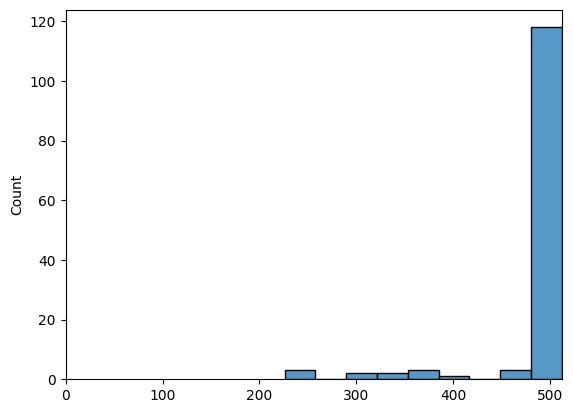

In [147]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [148]:
MAX_TOKEN_COUNT = 512

In [149]:


train_dataset = ArticleDataset(
  df_train,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['article', 'input_ids', 'attention_mask', 'label'])

In [150]:
sample_item

{'article': 'Gazdaságról ma nem beszélhetünk úgy, hogy ne reagálnánk – tudva vagy öntudatlanul – két hatalmas globális folyamatra. Az egyik a legutóbbi pénzügyi világválság lefutása: a fejlett világ magjából, az Egyesült Államokból indult ki, de minden kapcsolódó gazdaságot eltalált, a miénket különösen nagy erővel, 2008 őszén. A másik az újabb ipari-technológiai-információs forradalom.\n\nElég körbepillantani a metrón vagy (sajnos) az osztályteremben: a tekintetek jellemzően a monitoron, a telefonkijelzőn. A gyors és egyre olcsóbb információszerzés és tárolás átformálta az életünket, már eddig is alapjaiban érintett számos gazdasági tevékenységet. Felmérésekből jól tudható, hogy a robotok és algoritmusok révén hol és mennyi mostani munkatevékenység válik helyettesíthetővé már a legközelebbi jövőben.\n\nNem teljesen új dolog ez. A kapitalizmusnak Joseph Schumpeter által exponált jellemzője a teremtő rombolás (creative destruction). Ezt mi a térségben, más történelmi szituációban, a ren

In [151]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 10

def create_dataloader(df, tokenizer, max_token_len, batch_size):
    dataset = ArticleDataset(
        df,
        tokenizer=tokenizer,
        max_token_len=max_token_len
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1
    )

In [152]:
data_loader_train = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_test = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_eval = create_dataloader(df_eval, tokenizer, MAX_LEN, BATCH_SIZE)

In [153]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, return_dict=True, num_labels=number_of_labels)
model = model.to(device)
model.config.num_labels = number_of_labels

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [154]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in data_loader_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

Python(35953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch: 0, Loss: 3.1184263229370117
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(36199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 1, Loss: 3.060652732849121
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(36394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 2, Loss: 3.0306525230407715
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(36593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.05s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 3, Loss: 3.0662496089935303
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(36729) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 4, Loss: 2.895236015319824
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(36841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 5, Loss: 2.8876466751098633
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(36996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 6, Loss: 2.9522104263305664
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(37358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.16s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 7, Loss: 2.9127120971679688
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(37745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.17s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 8, Loss: 2.8032991886138916
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Python(38168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.16s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Epoch: 9, Loss: 2.623671054840088


In [155]:
model.eval()
eval_loss = 0
correct_labels = 0

with torch.no_grad():
    for batch in data_loader_eval:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        print(f"{logits.argmax(1)} : {labels}")
        correct_labels += (logits.argmax(1) == labels).sum().item()

# Calculate evaluation metrics
eval_len = len(data_loader_eval)
eval_loss /= eval_len
accuracy = correct_labels / eval_len

print(f"Evaluation Loss: {eval_loss}")
print(f"Accuracy: {accuracy}")

Python(38553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0.05s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


tensor([21, 18,  0,  2,  1,  0,  2, 21]) : tensor([0, 0, 0, 1, 1, 1, 2, 2])
tensor([21,  0,  0, 21, 21, 11,  0, 19]) : tensor([2, 3, 3, 3, 4, 4, 4, 5])
tensor([19, 19, 19, 21, 19, 21, 21, 14]) : tensor([5, 5, 6, 6, 6, 7, 7, 7])
tensor([ 2,  0,  0, 21, 21, 21, 21,  2]) : tensor([ 8,  8,  8,  9,  9,  9, 10, 10])
tensor([21, 19, 19, 21,  0, 21, 21, 19]) : tensor([10, 11, 11, 11, 12, 12, 12, 13])
tensor([ 2, 18,  0, 21,  0,  0,  0,  2]) : tensor([13, 13, 14, 14, 14, 15, 15, 15])
tensor([16,  2,  0, 18, 21, 21, 18,  3]) : tensor([16, 16, 16, 17, 17, 17, 18, 18])
tensor([19, 18, 21, 19, 19, 18, 19, 19]) : tensor([18, 19, 19, 19, 20, 20, 20, 21])
tensor([11,  2]) : tensor([21, 21])
Evaluation Loss: 3.015147394604153
Accuracy: 0.6666666666666666


In [55]:
correct_labels

10